<a href="https://colab.research.google.com/github/hanghae-plus-AI/AI-1-csn2506/blob/main/week3/Chapter2_%EC%8B%AC%ED%99%94%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3주차 심화과제
# - GPT로 뉴스 기사 분류 모델 학습하기

In [ ]:
!pip install tqdm boto3 requests regex sentencepiece sacremoses datasets

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


그 후, 우리가 사용하는 DistilBERT pre-training 때 사용한 tokenizer를 불러옵니다.

In [ ]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import AutoTokenizer

# tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'openai-gpt') # distilbert-base-uncased로 설정한 tokenizer와 encoder를 openai-gpt로 변경
tokenizer = AutoTokenizer.from_pretrained("openai-gpt", clean_up_tokenization_spaces=True)

tokenizer.pad_token = tokenizer.unk_token #GPT의 tokenizer는 padding token이 없어, 다음 코드로 padding token을 추가

DistilBERT의 tokenizer를 불러왔으면 이제 `collate_fn`과 data loader를 정의합니다. 이 과정은 이전 실습과 동일하게 다음과 같이 구현할 수 있습니다.

In [ ]:
ds = load_dataset("fancyzhx/ag_news")


def collate_fn(batch):
  max_len = 400
  texts, labels = [], []
  for row in batch:
    labels.append(row['label'])
    texts.append(row['text'])

  texts = torch.LongTensor(tokenizer(texts, padding=True,  max_length=max_len).input_ids) #Truncation과 관련된 부분들을 지움
  labels = torch.LongTensor(labels)

  return texts, labels


train_loader = DataLoader(
    ds['train'], batch_size=64, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    ds['test'], batch_size=64, shuffle=False, collate_fn=collate_fn
)

이제 pre-trained DistilBERT를 불러옵니다. 이번에는 PyTorch hub에서 제공하는 DistilBERT를 불러봅시다.

In [ ]:
model = torch.hub.load('huggingface/pytorch-transformers', 'model', 'openai-gpt')
model

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


OpenAIGPTModel(
  (tokens_embed): Embedding(40478, 768)
  (positions_embed): Embedding(512, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x Block(
      (attn): Attention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (c_fc): Conv1D()
        (c_proj): Conv1D()
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
  )
)

# Classify 할 때 사용하는 token representation 변경
  - 현재 `TextClassifier`는 첫 번째 token의 representation으로 label을 예측하고 있습니다.
  - 하지만 GPT의 pre-train 방식을 생각하면 첫 번째 token으로 label을 예측하면 안됩니다.
  - GPT의 pre-train 방식과 이전 RNN 실습에서 아이디어를 얻어 classify를 할 때 사용하는 token representation을 적절하게 변경하시면 됩니다.

In [ ]:
from torch import nn


class TextClassifier(nn.Module):
  def __init__(self):
    super().__init__()

    self.encoder = torch.hub.load('huggingface/pytorch-transformers', 'model', 'openai-gpt')
    self.classifier = nn.Linear(768, 4)

  def forward(self, x):
    x = self.encoder(x)['last_hidden_state']
    x = self.classifier(x[:, -1]) # 마지막토큰의 representation 사용

    return x


model = TextClassifier()

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


In [ ]:
for param in model.encoder.parameters():
  param.requires_grad = False

In [2]:
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1) # argmax를 사용하여 예측 클래스 계산


    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

def plot_acc(train_accs, test_accs, label1='train', label2='test'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, test_accs, label=label2)
  plt.legend()
  plt.show()

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2888: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch   0 | Train Loss: 1322.4538359344006
=========> Train acc: 0.831 | Test acc: 0.828
Epoch   1 | Train Loss: 1111.076494961977
=========> Train acc: 0.836 | Test acc: 0.831
Epoch   2 | Train Loss: 1086.1763862669468
=========> Train acc: 0.843 | Test acc: 0.839
Epoch   3 | Train Loss: 1074.8560039252043
=========> Train acc: 0.832 | Test acc: 0.830
Epoch   4 | Train Loss: 1065.0927681922913
=========> Train acc: 0.827 | Test acc: 0.827
Epoch   5 | Train Loss: 1063.9000805616379
=========> Train acc: 0.840 | Test acc: 0.838
Epoch   6 | Train Loss: 1061.409768357873
=========> Train acc: 0.842 | Test acc: 0.838
Epoch   7 | Train Loss: 1059.170365959406
=========> Train acc: 0.836 | Test acc: 0.834
Epoch   8 | Train Loss: 1054.6754803955555
=========> Train acc: 0.846 | Test acc: 0.844
Epoch   9 | Train Loss: 1057.946958899498
=========> Train acc: 0.834 | Test acc: 0.831


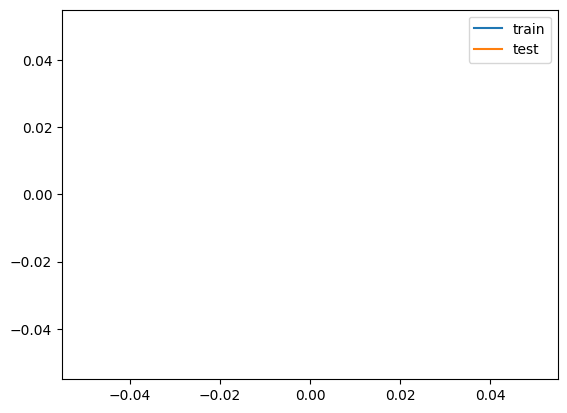

In [ ]:
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt


lr = 0.001
model = model.to('cuda')
loss_fn = nn.CrossEntropyLoss() # nn.CrossEntropyLoss()로 변경

optimizer = Adam(model.parameters(), lr=lr)
n_epochs = 10
train_accs, test_accs = [], []

for epoch in range(n_epochs):
  total_loss = 0.
  model.train()
  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

  with torch.no_grad():
    model.eval()
    train_acc = accuracy(model, train_loader)
    test_acc = accuracy(model, test_loader)

    print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")

plot_acc(train_accs, test_accs)

# 결과값 그래프 출력 추가

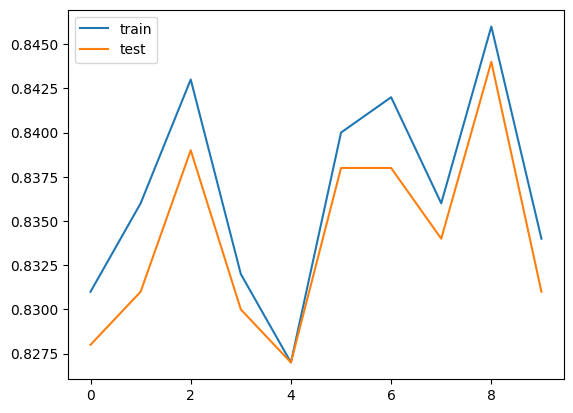

In [5]:
'''
Epoch   0 | Train Loss: 1322.4538359344006
=========> Train acc: 0.831 | Test acc: 0.828
Epoch   1 | Train Loss: 1111.076494961977
=========> Train acc: 0.836 | Test acc: 0.831
Epoch   2 | Train Loss: 1086.1763862669468
=========> Train acc: 0.843 | Test acc: 0.839
Epoch   3 | Train Loss: 1074.8560039252043
=========> Train acc: 0.832 | Test acc: 0.830
Epoch   4 | Train Loss: 1065.0927681922913
=========> Train acc: 0.827 | Test acc: 0.827
Epoch   5 | Train Loss: 1063.9000805616379
=========> Train acc: 0.840 | Test acc: 0.838
Epoch   6 | Train Loss: 1061.409768357873
=========> Train acc: 0.842 | Test acc: 0.838
Epoch   7 | Train Loss: 1059.170365959406
=========> Train acc: 0.836 | Test acc: 0.834
Epoch   8 | Train Loss: 1054.6754803955555
=========> Train acc: 0.846 | Test acc: 0.844
Epoch   9 | Train Loss: 1057.946958899498
=========> Train acc: 0.834 | Test acc: 0.831
'''

import numpy as np
import matplotlib.pyplot as plt
train_accs, test_accs, train_loss = [], [].[]

def plot_acc(train_accs, test_accs, train_loss, label1='train', label2='test', label3='train_loss'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  # plt.plot(x, test_accs, label=label2)
  # plt.plot(x, test_accs, label=label2)

  plt.legend()
  plt.show()


test_accs.append(0.828)
test_accs.append(0.831)
test_accs.append(0.839)
test_accs.append(0.830)
test_accs.append(0.827)
test_accs.append(0.838)
test_accs.append(0.838)
test_accs.append(0.834)
test_accs.append(0.844)
test_accs.append(0.831)

train_accs.append(0.831)
train_accs.append(0.836)
train_accs.append(0.843)
train_accs.append(0.832)
train_accs.append(0.827)
train_accs.append(0.840)
train_accs.append(0.842)
train_accs.append(0.836)
train_accs.append(0.846)
train_accs.append(0.834)

plot_acc(train_accs, test_accs)




Loss가 잘 떨어지고, 이전에 우리가 구현한 Transformer보다 더 빨리 수렴하는 것을 알 수 있습니다.